# Proyecto Final
Path Detection

---

**Martes 17 de junio del 2025**

In [1]:
# Import all required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Lambda, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CosineSimilarity
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm

Image dimensions: 320x160

Dataset Split:
Set          Samples    Shape          
----------------------------------------
Train        1745       (1745, 160, 320, 3)
Validation   375        (375, 160, 320, 3)
Test         375        (375, 160, 320, 3)


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - cosine_similarity: 0.2635 - loss: 0.0031 - val_cosine_similarity: 0.3707 - val_loss: 0.0024
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - cosine_similarity: 0.3141 - loss: 0.0023 - val_cosine_similarity: 0.3707 - val_loss: 0.0021
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - cosine_similarity: 0.3114 - loss: 0.0024 - val_cosine_similarity: 0.3760 - val_loss: 0.0019
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - cosine_similarity: 0.3053 - loss: 0.0023 - val_cosine_similarity: 0.3707 - val_loss: 0.0019
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - cosine_similarity: 0.3086 - loss: 0.0021 - val_cosine_similarity: 0.3760 - val_loss: 0.0018
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - cosine_similarity: 0.3592 - loss: 0.0021 - val_cosine_similarity: 0.3707 - val_loss: 0.0018
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - cosine_similarity: 0.2999 - loss: 0.0021 - val_cosine_simil

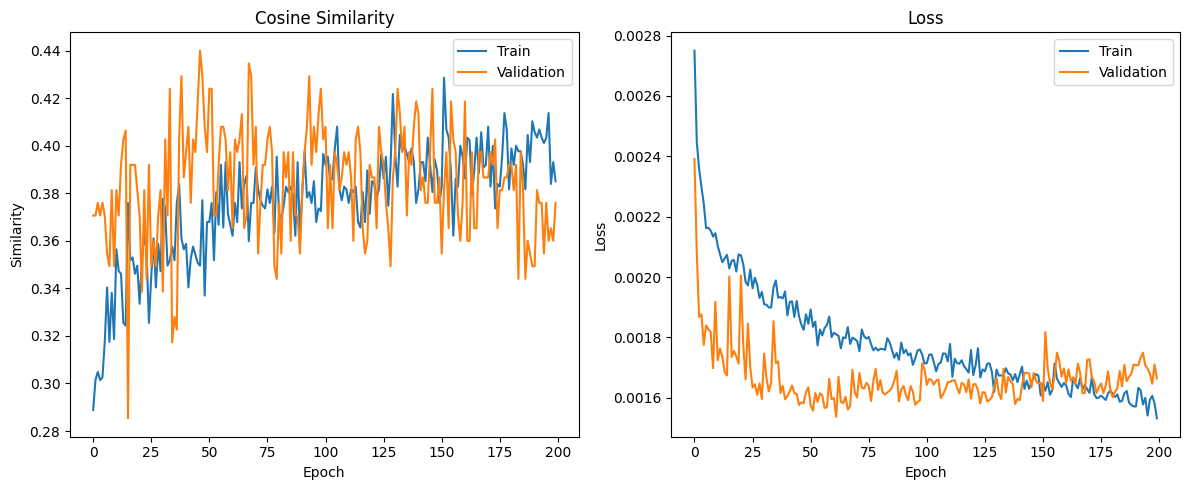

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


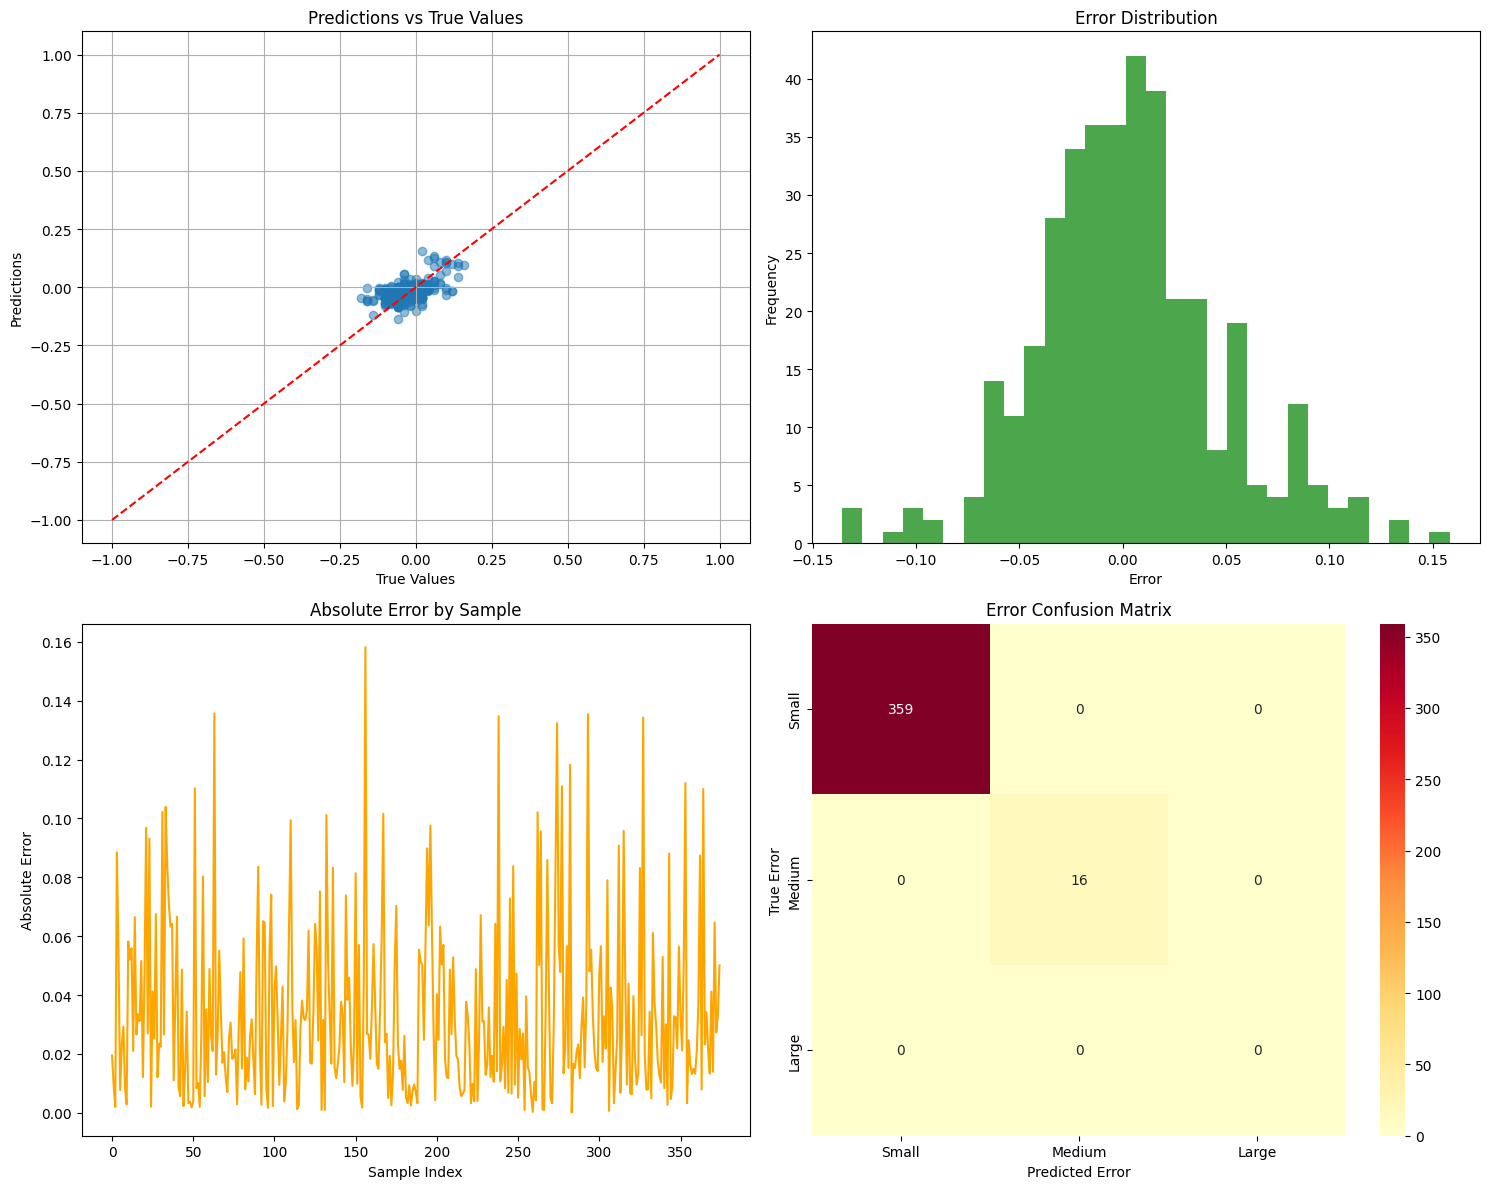


Model saved as 'modelo_conduccion.h5'


In [2]:
# Constants
IMG_PATH = 'data/imagenes_capturadas'
BATCH_SIZE = 32
EPOCHS = 200
RANDOM_STATE = 42

# Get image dimensions from first image
sample_image = Image.open(os.path.join(IMG_PATH, os.listdir(IMG_PATH)[0]))
IMG_WIDTH, IMG_HEIGHT = sample_image.size
print(f"Image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")

# Image preprocessing function
def load_and_preprocess_image(file_path):
    """Load, resize, convert to RGB and normalize image"""
    img = Image.open(file_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(img) / 255.0

# Load and prepare data
train_df = pd.read_csv('data/registro_conduccion.csv')
X = np.array([load_and_preprocess_image(os.path.join(IMG_PATH, fname)) for fname in train_df['nombre_imagen']])
y = train_df['angulo_direccion'].values

# Split data into train, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=RANDOM_STATE)

# Print dataset sizes
print("\nDataset Split:")
print(f"{'Set':<12} {'Samples':<10} {'Shape':<15}")
print("-" * 40)
print(f"{'Train':<12} {len(X_train):<10} {X_train.shape}")
print(f"{'Validation':<12} {len(X_val):<10} {X_val.shape}")
print(f"{'Test':<12} {len(X_test):<10} {X_test.shape}")

# Data augmentation setup
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Build CNN model (DAVE-2 inspired architecture)
model = Sequential([
    Lambda(lambda x: x * 2. - 1., input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(24, (5, 5), strides=(2, 2), activation='elu'),
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(1164, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='tanh')
])

# Compile model
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-4),
    metrics=[CosineSimilarity()]
)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("\nModel Evaluation:")
print(f"{'Metric':<20} {'Value':<10}")
print("-" * 30)
print(f"{'Test Accuracy':<20} {test_acc:.4f}")
print(f"{'Test Loss':<20} {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['cosine_similarity'], label='Train')
plt.plot(history.history['val_cosine_similarity'], label='Validation')
plt.title('Cosine Similarity')
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Model predictions and analysis
y_pred = model.predict(X_test)
errors = y_pred.flatten() - y_test
abs_errors = np.abs(errors)

# Plot predictions analysis
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-1,1], [-1,1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(errors, bins=30, alpha=0.7, color='green')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.subplot(2, 2, 3)
plt.plot(abs_errors, color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.title('Absolute Error by Sample')

plt.subplot(2, 2, 4)
error_bins = [-np.inf, 0.1, 0.3, np.inf]
error_labels = ['Small', 'Medium', 'Large']
error_categories = np.digitize(abs_errors, bins=error_bins)
cm = confusion_matrix(error_categories, error_categories, labels=[1, 2, 3])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=error_labels, yticklabels=error_labels, cmap='YlOrRd')
plt.xlabel('Predicted Error')
plt.ylabel('True Error')
plt.title('Error Confusion Matrix')
plt.tight_layout()
plt.show()

# Save model
model.save('modelo_conduccion.h5')
print("\nModel saved as 'modelo_conduccion.h5'")

# Prediction function
def cargar_y_predecir(ruta_imagen):
    """Load model and predict steering angle for an image"""
    modelo_cargado = load_model('modelo_conduccion.h5', 
                              custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    img = load_and_preprocess_image(ruta_imagen)
    return modelo_cargado.predict(np.expand_dims(img, axis=0))[0][0]
